# Abstract neural nets

In this specific notebook, we will examine the process of training neural networks that consist of densely connected and convolutional layers. The specific models that we will be utilizing can be altered and modified according to the provided structure (therefore, the classes implementing this functionality may be considered abstract constructors).

## Table of contents

You can navigate over the document using these hyperlinks:
* [Data preparation](#Data-preparation)
* [Dense net exaple](#Dense-net-example)
* [Convolutional net example](#Convolutional-net-example)
* [Conclusion](#Conclusion)

Now let's begin.

***

## Imports

Below we have listed the imports of the Matplotlib pyplot module, the `randint` function from the NumPy library, and the `read_csv` function from the Pandas library. These modules and functions will be required to visualize and manipulate the data in our analysis. Additionally, we have imported certain modules from the Scratchpad library, examples of which will be provided throughout the document.

In [1]:
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from pandas import read_csv

from scratches.preprocessing import (
    DataSplitter,
    normalize_data,
    reshape_channel_images,
    revert_matrix,
    tokenize_probabilities,
    transform_binary,
)
from scratches.models.evaluation import (
    compute_accuracy,
    compute_confusion_matrix,
)
from scratches.models.abstract import (
    ConvolutionalLayer,
    DenseLayer,
    NeuralNetwork,
    Trainer,
    TanHFunctionOperator,
    SGDMomentumOptimizer,
    SigmoidFunctionOperator,
    SoftmaxCEEvaluator,
)

***

## Data preparation

Every machine learning project begins with the data preprocessing stage. This notebook is no different.

### Loading the data

Let us load the MNIST dataset, which consists of 70,000 28x28 pixel images of labeled numbers from 0 to 9. This dataset will be used for both fully connected and convolutional neural networks. Before we can use it, we must first unzip it.

In [2]:
with ZipFile("datasets/mnist.zip", "r") as zip_ref:
    zip_ref.extractall("datasets")

data = read_csv("datasets/mnist.csv")

Now, let us consider a random digit from our data set.

We have encapsulated the image demonstration code in a function, as we will need to repeat the process later.

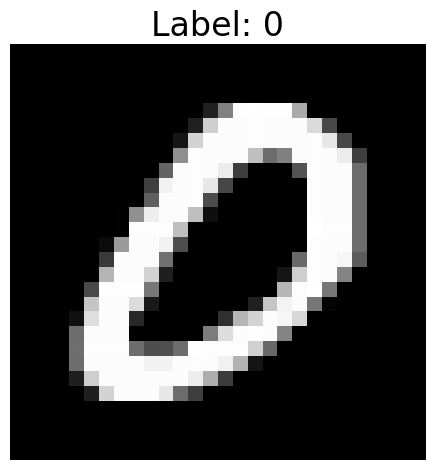

In [3]:
def show_random_image(images: ndarray, title: str) -> None:
    index = np.random.randint(0, len(images))
    image, label = (images[index, 1:].reshape((28, 28)), images[index, 0])

    plt.axis("off")
    plt.title(f"{title}: {int(label)}", fontsize=24)
    plt.tight_layout()
    plt.imshow(image, cmap="grey")


data_numpy = data.to_numpy()

show_random_image(data_numpy, "Label")

### Preprocessing the data

In the following steps, we have divided the dataset into training, validation, and testing sets using the `DataSplitter` class. After that, we need to encode the labels as one-hot vectors using the `transform_binary()` function to train and validate our model.

In [4]:
splitter = DataSplitter(permute=True, random_seed=20240604)
x_train, x_valid, x_test, y_train, y_valid, y_test = splitter.split_data(
    data.drop(columns=["label"]).to_numpy(),
    data["label"].to_numpy().reshape((-1, 1)),
    test_size=0.15,
    valid_size=0.20,
)
y_train, y_valid = transform_binary(y_train), transform_binary(y_valid)

Additionally, normalizing our training data using the `normalize_data()` function can accelerate the training process and improve the overall accuracy of the model.

In [5]:
x_train, x_valid, x_test = (
    normalize_data(to_normalize=x_train, std_from=x_train),
    normalize_data(to_normalize=x_valid, std_from=x_train),
    normalize_data(to_normalize=x_test, std_from=x_train),
)

***

## Dense net example

Now we come to the first interesting part of the notebook – defining the structure and training our model.

### Defining a model

You can find the list of steps required to build a model below.

* Initialize the dictionary of layers, in the order that they need to consume data, using the `DenseLayer` class.
* Initialize an optimizer (in this case, `SGDMomentumOptimizer`) that will adjust the parameters of the model.
* Create the network with the `NeuralNetwork` class by specifying the layers and loss function (here, we have `SoftmaxCEEvaluator`).
* Initialize a trainer for your model using the `Trainer` class and provide the model and optimizer as arguments.
* Train the model on the data by calling the `Trainer.fit` method.
The order of initialization can be modified.

A list of all available parameters and their detailed descriptions can be found in the code as documentation.

In [6]:
dense_layers = {
    "dense0": DenseLayer(
        n_neurons=46,
        activation_function=TanHFunctionOperator(),
        weight_initialization="Glorot",
        dropout_rate=0.8,
    ),
    "output": DenseLayer(
        n_neurons=10,
        activation_function=SigmoidFunctionOperator(),
        weight_initialization="Glorot",
    ),
}
optimizer = SGDMomentumOptimizer(
    learning_rate=0.3,
    final_learning_rate=0.05,
    momentum=0.8,
    decay_type="exponential"
)
dense_net = NeuralNetwork(
    layers=dense_layers,
    loss_function=SoftmaxCEEvaluator(),
    random_seed=20240604,
)
trainer = Trainer(network=dense_net, optimizer=optimizer)

trainer.fit(
    x_train,
    x_valid,
    y_train,
    y_valid,
    epochs=120,
    evaluate_every_epochs=10,
    batch_size=60,
    stop_early=False,
    random_seed=20240604,
)

Trainer: Validation loss after 10 epochs is 7.084716235388116.
Trainer: Validation loss after 20 epochs is 7.000090724657273.
Trainer: Validation loss after 30 epochs is 6.968703016234528.
Trainer: Validation loss after 40 epochs is 6.956873851974652.
Trainer: Validation loss after 50 epochs is 6.944703315768021.
Trainer: Validation loss after 60 epochs is 6.942760204005265.
Trainer: Validation loss after 70 epochs is 6.936637668747019.
Trainer: Validation loss after 80 epochs is 6.940921979025974.
Trainer: Validation loss after 90 epochs is 6.925552523945191.
Trainer: Validation loss after 100 epochs is 6.934404005709101.
Trainer: Validation loss after 110 epochs is 6.925215336435472.
Trainer: Validation loss after 120 epochs is 6.921328001866581.
Trainer: Training complete! It took 77.27190427999994 seconds.


### Evaluating the model

We now need to evaluate the accuracy of our model. We can examine the exact results of predicting test labels in the confusion matrix output of the cell below. However, the conversion of the one-hot encoded vectors to actual digits must first be performed using the `tokenize_probabilities()` function (translates probabilities to a binary matrix) and the `revert_matrix()` function (converts the binary matrix to a vector of actual digits).

Additionally, the code for visualizing the confusion matrix should be incorporated into a separate function, as it will be used once more.

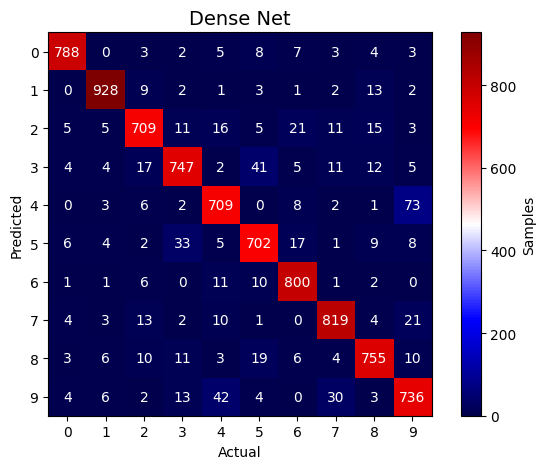

In [7]:
def visualize_confusion_matrix(
    title: str, actual: ndarray, predicted: ndarray
) -> None:
    confusion_matrix, _ = compute_confusion_matrix(actual, predicted)
    figure, axis = plt.subplots()
    ticks = list(range(0, len(confusion_matrix)))

    axis.set_yticks(ticks)
    axis.set_xticks(ticks)
    axis.set_xlabel("Actual")
    axis.set_ylabel("Predicted")
    for i, _ in enumerate(confusion_matrix):
        for j, _ in enumerate(confusion_matrix):
            axis.text(
                j, i, int(confusion_matrix[i, j]),
                verticalalignment="center",
                horizontalalignment="center",
                color="white"
            )
    axis.set_title(title, fontsize=14)
    to_show = plt.imshow(confusion_matrix, cmap="seismic")
    figure.colorbar(to_show, label="Samples")

    plt.tight_layout()
    plt.show()


y_predicted = dense_net.feed_forward(x_test)
y_predicted = revert_matrix(tokenize_probabilities(y_predicted))

visualize_confusion_matrix("Dense Net", y_test, y_predicted)

For numerical accuracy, you can make use of the `compute_accuracy()` function, which returns a decimal score for the model. In this case, we have achieved some impressive results, with a percentage equivalent of 92.357.

In [8]:
compute_accuracy(y_test, y_predicted)

np.float64(0.9158333333333334)

For a detailed review, you can now select a random image and predicted label to view, by executing the following cell.

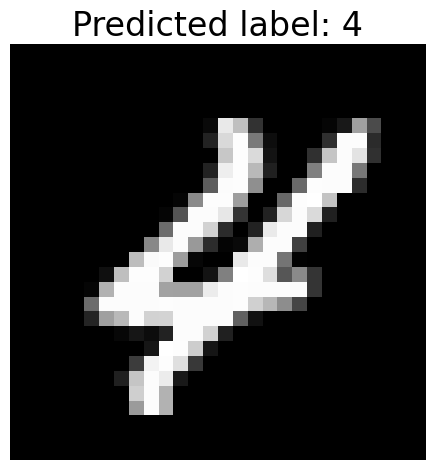

In [9]:
images_and_predictions = np.concatenate([y_predicted, x_test], axis=1)

show_random_image(images_and_predictions, "Predicted label")

***

## Convolutional net example

In the following images, we illustrate the process of building the convolutional neural network (CNN). This is not exactly the same as what we saw earlier. Let us take a closer look at the differences between these two processes.

### Additional data reshaping

Before initialization, we need to reshape our current data, as our model will no longer treat it as a simple set of numerical values (and will not attempt to determine the connections between points). Instead, the model will now view the data as an image, attempting to identify actual patterns and their significance in relation to the content of the image.

Below, we use the `reshape_channel_images` function to convert our column vector of pixel values into channel images (assuming that all previous data preprocessing steps have already been completed).

In [10]:
x_train_conv, x_valid_conv, x_test_conv = (
    reshape_channel_images(x_train, 1, image_height=28, image_width=28),
    reshape_channel_images(x_valid, 1, image_height=28, image_width=28),
    reshape_channel_images(x_test, 1, image_height=28, image_width=28),
)

### Defining a model

Now that we have the perfect dataset for our network, we are able to train it. However, before we do so, let's take a look at the different layers.

In order to initialize the first layer, we use the `ConvolutionalLayer` class. This layer performs convolutions on our images in order to detect patterns. The overall procedure is not significantly different from the previous one, except that this time, we specify the number of output channels and the size of the parameter kernel instead of the number of neurons.

In [11]:
conv_layers = {
    "conv0": ConvolutionalLayer(
        output_channels=8,
        parameter_size=7,
        activation_function=TanHFunctionOperator(),
        weight_initialization="Glorot",
        dropout_rate=0.8,
        apply_flatten=True,
    ),
    "output": DenseLayer(
        n_neurons=10,
        activation_function=SigmoidFunctionOperator(),
        weight_initialization="Glorot",
    ),
}
optimizer = SGDMomentumOptimizer(
    learning_rate=0.1,
    final_learning_rate=0.05,
    momentum=0.9,
    decay_type="exponential"
)
conv_net = NeuralNetwork(
    layers=conv_layers,
    loss_function=SoftmaxCEEvaluator(),
    random_seed=20240604,
)
trainer = Trainer(network=conv_net, optimizer=optimizer)

trainer.fit(
    x_train_conv,
    x_valid_conv,
    y_train,
    y_valid,
    epochs=3,
    evaluate_every_epochs=1,
    evaluate_every_batches=100,
    batch_size=60,
    random_seed=20240604,
)

Trainer: Loss after 100 batches is 4.232614890382931.
Trainer: Loss after 200 batches is 3.7506101245268106.
Trainer: Loss after 300 batches is 3.6804866479625074.
Trainer: Loss after 400 batches is 3.702429367742.
Trainer: Loss after 500 batches is 3.6455449280918772.
Trainer: Loss after 600 batches is 3.617567769554827.
Trainer: Loss after 700 batches is 3.615307699993776.
Trainer: Loss after 800 batches is 3.600226858425856.
Trainer: Loss after 900 batches is 3.652726484013988.
Trainer: Validation loss after 1 epochs is 7.040715317394171.
Trainer: Loss after 100 batches is 3.592948168357799.
Trainer: Loss after 200 batches is 3.6379382424313205.
Trainer: Loss after 300 batches is 3.579050040874129.
Trainer: Loss after 400 batches is 3.598875052424894.
Trainer: Loss after 500 batches is 3.6074874921344615.
Trainer: Loss after 600 batches is 3.6695160480122495.
Trainer: Loss after 700 batches is 3.581006177082538.
Trainer: Loss after 800 batches is 3.5792735457019593.
Trainer: Loss af

### Evaluating the model

The model has successfully been trained. We can now take a look at the results in the confusion matrix, which is output in the cell below.

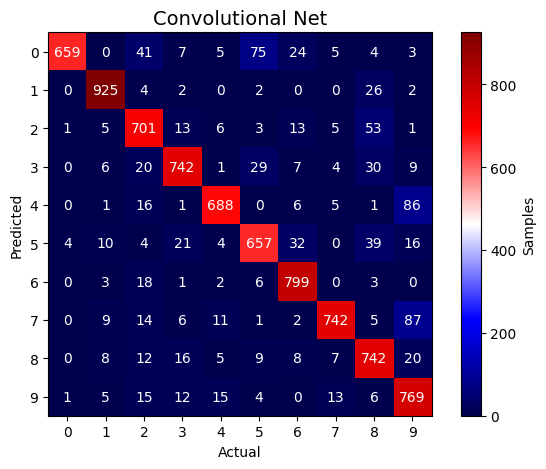

In [12]:
y_predicted = conv_net.feed_forward(x_test_conv)
y_predicted = revert_matrix(tokenize_probabilities(y_predicted))

visualize_confusion_matrix("Convolutional Net", y_test, y_predicted)

And here is a part of the dataset that has been accurately predicted.

In [13]:
compute_accuracy(y_test, y_predicted)

np.float64(0.8838095238095238)

Although it took some time (due to the complexity of the task), the model learned faster than the dense network in terms of number of epochs and iterations. Furthermore, the accuracy was very impressive even after just 3 epochs of training. Note that the dense network required 40 epochs in order to reach the same level of accuracy as the convolutional network.

Similar to the dense network, you can execute the following code cell in order to select a random image from the dataset with the predicted class label.

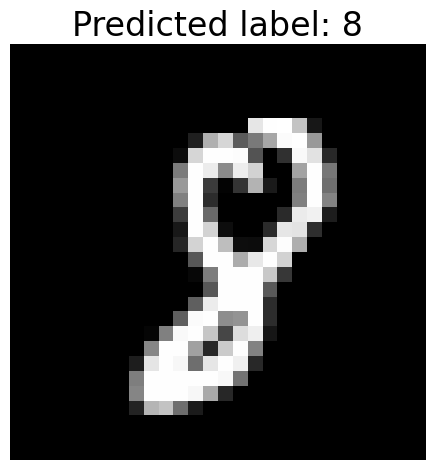

In [14]:
images_and_predictions = np.concatenate([y_predicted, x_test], axis=1)

show_random_image(images_and_predictions, "Predicted label")

***

## Conclusion

In this document, we have covered the basic concepts and reviewed some examples of using abstract model constructors to build simple neural networks. You may have already mentioned that the process is very similar to that of PyTorch.

In conclusion, predictions are fairly accurate. Although the training process may take some time, you are still able to achieve good results.

After seeing how to use the neural network constructors (for educational purposes only, of course), you can experiment with them by referring to the source code for documentation.